<a href="https://colab.research.google.com/github/AdrianLorenzoDev/xray-pneumonia-detection/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Image classifier to detect pneumonia

Dataset:
> Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
> http://dx.doi.org/10.17632/rscbjbr9sj.2

In [0]:
from google.colab import drive
drive.mount("/content/drive")

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

In [0]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image

## Data augmentation

In [0]:
trainDataDir = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/train/'
validationDataDir = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/test/'


batchSize = 16
width = 224
height = 224


trainDataGen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=9,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validationDataGen = ImageDataGenerator(
    rescale=1./255
)

trainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='grayscale'
)

validationGenerator = validationDataGen.flow_from_directory(
    validationDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model

In [0]:
model = Sequential([
    Conv2D(32, (3,3), activation=relu, input_shape=(width, height, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation=relu),  
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation=relu),
    Dropout(0.5),
    Dense(512, activation=relu),
    Dense(1, activation=sigmoid)
])

In [0]:
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)       147584    
__________

In [0]:
checkPointer = ModelCheckpoint(filepath='./weights.hdf5', monitor="val_acc", verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', mode='auto', baseline=None, restore_best_weights=False, patience = 8)

# class_weight = {0.0 : 0.74,
#                1.0 : 0.26}

history = model.fit_generator(
    generator = trainGenerator,
    steps_per_epoch = trainGenerator.samples // batchSize,
    epochs=80,
    validation_data = validationGenerator,
    validation_steps = validationGenerator.samples // batchSize,
#    class_weight=class_weight,
    callbacks=[checkPointer, earlyStopping]
)

Epoch 1/80
39/39 [==============================] - 7s 170ms/step - loss: 0.4669 - acc: 0.7917

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to ./weights.hdf5
326/326 [==============================] - 82s 251ms/step - loss: 0.4561 - acc: 0.7761 - val_loss: 0.4669 - val_acc: 0.7917
Epoch 2/80
39/39 [==============================] - 7s 168ms/step - loss: 0.4289 - acc: 0.8157

Epoch 00002: val_acc improved from 0.79167 to 0.81571, saving model to ./weights.hdf5
326/326 [==============================] - 79s 243ms/step - loss: 0.3194 - acc: 0.8599 - val_loss: 0.4289 - val_acc: 0.8157
Epoch 3/80
39/39 [==============================] - 7s 170ms/step - loss: 0.4595 - acc: 0.7804

Epoch 00003: val_acc did not improve from 0.81571
326/326 [==============================] - 78s 240ms/step - loss: 0.2815 - acc: 0.8744 - val_loss: 0.4595 - val_acc: 0.7804
Epoch 4/80
39/39 [==============================] - 7s 168ms/step - loss: 0.3650 - acc: 0.8365

Epoch 00004: val_acc impr

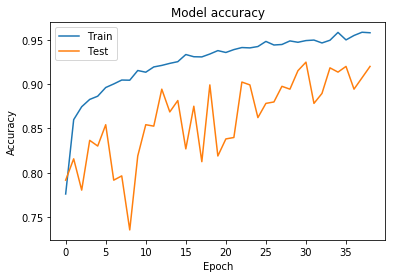

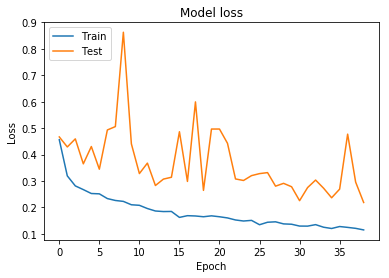

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("./weights.hdf5")

## Final validation, confusion matrix and classification report

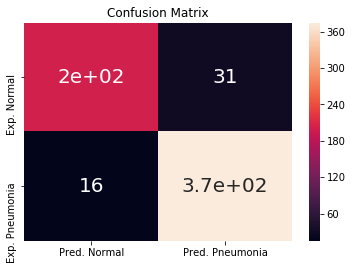

In [0]:
valResult = model.predict_generator(validationGenerator, validationGenerator.samples // batchSize)
valProb = valResult.copy()
valResult[valResult <= 0.5] = 0
valResult[valResult > 0.5] = 1
confMatrixdf = pd.DataFrame(
    confusion_matrix(validationGenerator.classes, valResult),
    index=["Exp. Normal", "Exp. Pneumonia"],
    columns=["Pred. Normal", "Pred. Pneumonia"]
)

plt.title("Confusion Matrix")
sn.heatmap(confMatrixdf, annot=True, annot_kws={"size" : "20"})

In [0]:
print("\nReport: \n", classification_report(validationGenerator.classes, valResult, target_names = ["Normal", "Pneumonia"]))


Report: 
               precision    recall  f1-score   support

      Normal       0.93      0.87      0.90       234
   Pneumonia       0.92      0.96      0.94       390

   micro avg       0.92      0.92      0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



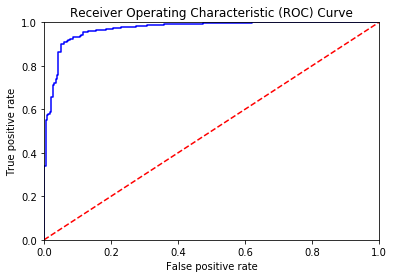

In [0]:
fpr, tpr, thresholds = roc_curve(validationGenerator.classes, valProb)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()


## Small testing

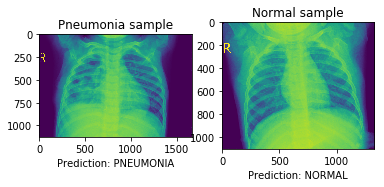

In [0]:
pneumoniaImage = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg')
normalImage = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg')

plt.subplot(1,2,1)
plt.imshow(np.asarray(pneumoniaImage))
pneumoniaData = np.array(pneumoniaImage.resize((width,height), Image.ANTIALIAS)).reshape(1, width, height, 1)/255
plt.title("Pneumonia sample")
plt.xlabel("Prediction: " + ("PNEUMONIA" if model.predict_classes(pneumoniaData) else "NORMAL"))

plt.subplot(1,2,2)
plt.imshow(np.asarray(normalImage))
normalData = np.array(normalImage.resize((width,height), Image.ANTIALIAS)).reshape(1, width, height, 1)/255
plt.title("Normal sample")
plt.xlabel("Prediction: " + ("PNEUMONIA" if model.predict_classes(normalData) else "NORMAL"))
plt.show()